In [504]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


In [505]:
T = 2 * np.pi
n = 1000
h = T / n

Q = np.array([[100, 0, 0],[0, 100, 0],[0, 0, 0.1]])
R = np.array([[0.1, 0],[0, 0.1]])
P_1 = np.array([[10, 0, 0],[0, 10, 0],[0, 0, 10]])

# Goal Trajectory
x_g = np.zeros((n,3))
for i in range(n):
    x_g[i,0] = 2*h*i/np.pi
    x_g[i,2] = np.pi/2

In [506]:
# Dynamics
def dynamics(x0, u):
    x = np.zeros((n,3))
    x[0] = x0
    for i in range(n-1):
        x[i+1,2] = x[i,2] + h*u[i,1]
        x[i+1,0] = x[i,0] + h*np.cos(x[i,2])*u[i,0]
        x[i+1,1] = x[i,1] + h*np.sin(x[i,2])*u[i,0]
    return x

In [507]:
# Cost Function
def J(x, u):
    intg = 0
    for i in range(n):
        intg += h*(np.dot(np.dot((x[i] - x_g[i]).T, Q), (x[i]-x_g[i])) + np.dot(np.dot(u[i].T, R), u[i]))
    final_cost = np.dot(np.dot((x[-1] - x_g[-1]).T, P_1), (x[-1]-x_g[-1]))
    return intg + final_cost

# Cost Function Directional Derivative
def DJ(x, u, zeta):
    intg = 0
    for i in range(n):
        intg += h*2*(np.dot(np.dot((x[i] - x_g[i]).T, Q), zeta[i, :3]) + np.dot(np.dot(u[i].T, R), zeta[i, 3:]))
    D_final_cost = 2*np.dot(np.dot((x[-1] - x_g[-1]).T, P_1), zeta[-1, :3])
    return intg + D_final_cost

In [508]:
# Get zeta
def get_zeta(x, u):
    # (a.T, b.T) = D l(x, u) = (2(x-x_g).T Q, 2u.T R) 
    # A(t) = D1 f(x,u)
    # B(t) = D2 f(x,u)
    A = np.zeros((n,3,3)) # Time, Matrix
    B = np.zeros((n,3,2)) # Time, Matrix
    for i in range(n):
        A[i] = [[0, 0, -np.sin(x[i,2])*u[i,0]], [0, 0, np.cos(x[i,2])*u[i,0]], [0, 0, 0]]
        B[i] = [[np.cos(x[i,2]), 0], [np.sin(x[i,2]), 0], [0, 1]] 

    zeta = np.zeros((n,5))
    P = np.zeros((n,3,3)) # Time, Matrix
    r = np.zeros((n,3)) # Time, Vector
    P[n-1] = P_1
    r[n-1] = [0, 0, 0]

    i = n-1
    while i > 0:
        P_dot = -np.dot(P[i], A[i]) - np.dot(A[i].T, P[i]) + np.dot(np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), B[i].T), P[i]) - Q
        r_dot = np.dot(np.dot(np.dot(P[i], B[i]), np.linalg.inv(R)), 2*np.dot(u[i].T, R).T) - 2*np.dot((x[i] - x_g[i]).T, Q).T - np.dot((A[i] - np.dot(np.dot(np.dot(B[i], np.linalg.inv(R)), B[i].T), P[i])).T, r[i])
        P[i-1] = P[i] - h*P_dot
        r[i-1] = r[i] - h*r_dot
        
        i -= 1

    zeta[0, :3] = [0, 0, 0]
    #zeta[0, :3] = -np.dot(np.linalg.inv(P[0]), r[0])
    for i in range(n-1):
        zeta[i, 3:] = -np.dot(np.dot(np.dot(np.linalg.inv(R), B[i].T), P[i]), zeta[i, :3]) - np.dot(np.dot(np.linalg.inv(R), B[i].T), r[i]) - np.dot(np.linalg.inv(R), 2*np.dot(u[i].T, R).T)
        zeta[i+1, :3] = zeta[i, :3] + h*(np.dot(A[i], zeta[i, :3]) + np.dot(B[i], zeta[i, 3:]))
    return zeta

In [509]:
# Initial Trajectory
x0 = [0,0,np.pi/2]
u_init = np.zeros((n,2))
for i in range(n-1):
    u_init[i] = [1, -0.5]
x_init = dynamics(x0, u_init)

# Initial Cost
#J_init = J(x_init, u_init)
#print(J_init)

In [510]:
# iLQR
eps = 1.1E-3 # Threshold

u_iLQR = u_init
x_iLQR = x_init

zeta = np.zeros((n,5)) # zeta = [z0, z1, z2, v0, v1]
J_array = []

i = 0
while i==0 or np.abs(DJ(x_iLQR, u_iLQR, zeta)) > eps:
    print(np.abs(DJ(x_iLQR, u_iLQR, zeta)))
    # zeta = argmin(DJ(u)*zeta) + 0.5*np.dot(zeta.T, zeta)
    zeta = get_zeta(x_iLQR, u_iLQR)
    #print(zeta[-1])
    
    # Armijo
    alpha = 0.1
    beta = 0.5
    gamma = 1
    J_u = J(x_iLQR, u_iLQR)
    J_array.append(J_u)
    DJ_u_zeta = DJ(x_iLQR, u_iLQR, zeta)
    while J(dynamics(x0, u_iLQR + gamma*zeta[:, 3:]), u_iLQR + gamma*zeta[:, 3:]) > J_u + alpha*gamma*DJ_u_zeta:
        gamma *= beta

    # Update u, x for all times
    for j in range(n):
        u_iLQR[j] += gamma*zeta[j, 3:]
    x_iLQR = dynamics(x0, u_iLQR)
    i += 1


0.0
584.8166269845609
324.6391781527544
76.00365586680753
39.521154606789565
1.4101421753307095
7.447181679725008
6.172029843997729
8.70555475827917
19.625310354592145
1.6115056517674673
4.615252501167312
3.3321068199037738
3.5902500130100536
1.9661148771761428
1.7048323611258236
1.5186891539362335
1.338787087140544
1.1528087882621407
1.0331127663798783
0.8672710102003488
0.8004576956278577
0.6525564824992945
1.0113028456929336
0.5170343043867733
0.39121023920168724
0.3539242865685735
0.3287773304948201
0.26693140044613983
0.258350785511064
0.1972857531366769
0.21019932571961528
0.14557329155919446
0.37592111088449276
0.11162045203152647
0.06111306758325962
0.06252888461239282
0.06985104841612966
0.04682039095356383
0.053118087130353
0.03046580829344276
0.04367566883428553
0.018217950879732693
0.03765752805712
0.008932693308349775
0.16400710190453127
0.010509238861682212
0.021034994322829875


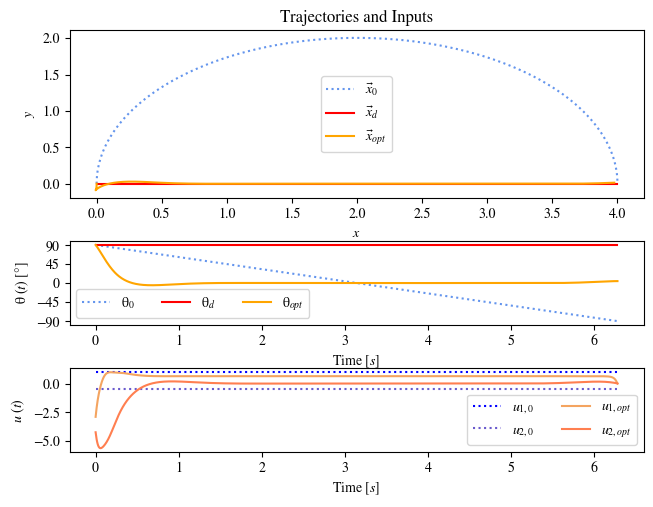

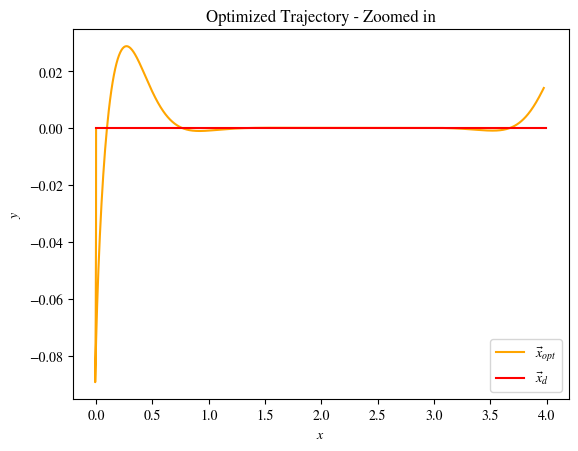

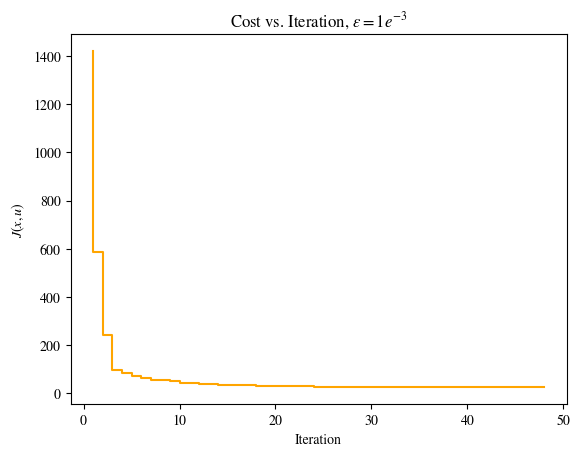

In [511]:
# Plots: Initial Trajectory, Final Optimized Trajectory, Optimized Control Signal
time_discr = np.linspace(0, T, n)

#Plot Initial Trajectory
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, height_ratios=[2, 1, 1])
fig.tight_layout()
ax1.plot(x_init[:,0], x_init[:,1], color='cornflowerblue', linestyle='dotted', label=r'$\vec{x}_{0}$')
ax1.plot(x_g[:,0], x_g[:,1], color='red', label=r'$\vec{x}_{d}$')
ax1.plot(x_iLQR[:,0], x_iLQR[:,1], color='orange', label=r'$\vec{x}_{opt}$')
ax2.plot(time_discr, x_init[:,2]*180/np.pi, color='cornflowerblue', linestyle='dotted', label="\u03B8$_{0}$")
ax2.plot(time_discr, x_g[:,2]*180/np.pi, color='red', label="\u03B8$_{d}$")
ax2.plot(time_discr, x_iLQR[:,2]*180/np.pi, color='orange', label="\u03B8$_{opt}$")
ax3.plot(time_discr, np.array([1 for i in range(n)]), color='blue', linestyle='dotted', label="$u_{1,0}$")
ax3.plot(time_discr, np.array([-0.5 for i in range(n)]), color='slateblue', linestyle='dotted', label="$u_{2,0}$")
ax3.plot(time_discr, u_iLQR[:,0], color='sandybrown', label="$u_{1,opt}$")
ax3.plot(time_discr, u_iLQR[:,1], color='coral', label="$u_{2,opt}$")

ax1.legend()
ax2.legend(ncol=3, loc='lower left')
ax3.legend(ncol=2)

ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
ax2.set_xlabel("Time $[s]$")
ax2.set_ylabel("\u03B8 $(t)$ $[°]$")
ax2.set_yticks([-90, -45, 0, 45, 90])
ax3.set_xlabel("Time $[s]$")
ax3.set_ylabel("$u$ $(t)$")

ax1.set_title("Trajectories and Inputs")
plt.savefig('./HW2_1_traj.png', bbox_inches='tight', dpi=600)

#Plots Final Optimized Trajectory
# fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
# ax1.step(time_discr, x_iLQR[:,0], label="$x$")
# ax2.step(time_discr, x_iLQR[:,1], label="$y$")
# ax1.step(time_discr, x_g[:,0], color='red', label=r"$x_{d}$")
# ax2.step(time_discr, x_g[:,1], color='red', label=r"$y_{d}$")
# ax3.step(time_discr, x_iLQR[:,2]*180/np.pi, label="\u03B8")
# ax3.step(time_discr, x_g[:,2]*180/np.pi, color='red', label="\u03B8$_{d}$")
# ax1.set_ylabel("$x$ $(t)$")
# ax2.set_ylabel("$y$ $(t)$")
# ax3.set_xlabel("Time $[s]$")
# ax3.set_ylabel("\u03B8 $(t)$ $[°]$")
# ax1.legend()
# ax2.legend()
# ax3.legend()
# ax1.set_title("Final Optimized Trajectory")
# plt.savefig('./HW2_1_opt_time.png')

fig3, ax = plt.subplots()
ax.plot(x_iLQR[:,0], x_iLQR[:,1], color='orange', label=r'$\vec{x}_{opt}$')
ax.plot(x_g[:,0], x_g[:,1], color='red', label=r'$\vec{x}_{d}$')
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.title("Optimized Trajectory - Zoomed in")
plt.savefig('./HW2_1_opt_zoom.png', bbox_inches='tight', dpi=600)

# Plot Optimized Control Signal
# fig4, ax = plt.subplots()
# ax.step(time_discr, u_iLQR[:,0], label="$u_{1}$")
# ax.step(time_discr, u_iLQR[:,1], label="$u_{2}$")
# ax.legend()
# ax.set_xlabel("Time $[s]$")
# ax.set_ylabel("$u$ $(t)$")
# plt.title("Optimized Controls")
# plt.savefig('./HW2_1_opt_u.png')

fig5, ax = plt.subplots()
ax.step(np.linspace(1, i, i), J_array, color='orange')
ax.set_xlabel("Iteration")
ax.set_ylabel("$J(x, u)$")
plt.title("Cost vs. Iteration, $\epsilon = 1e^{-3}$")
plt.savefig('./HW2_1_cost.png', dpi=600)